<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px;">

## Image Compression Using Principal Component Analysis (PCA) and Singular Value Decomposition (SVD)

_Author: Kiefer Katovich (SF) _

---

In this lab, we’ll write principal component analysis (PCA) and singular value decomposition (SVD) from scratch and use them to compress and reconstruct images.

### Learning Objectives

- Understand grayscale image processing using NumPy.
- Explore the mathematics of PCA and SVD.
- Manually implement PCA and SVD.
- Build an image compression algorithm.

Below is an overview of the math behind PCA and a method for calculating it, SVD (which is common in many algorithms).

### Lesson Guide
- [1) Load the Data Set](#1.-Load-Dataset)
- [2) Understand the Data Set](#2.-Understand-the-Dataset)
- [3) Covariance of a Matrix](#3.-Covariance-of-a-Matrix)
- [4) An Ideal Data Representation](#4.-An-Ideal-Data-Representation) (the math of PCA)
- [5) Manually Code PCA](#5.-Manually-Coding-PCA)
- [6) Singular Value Decomposition (SVD) to Perform PCA](#svd)
- [7) Manually Code SVD](#7.-Manually-Coding-SVD)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Faces Data Set
---

Let's load in the faces data set from scikit-learn and pull out one of the faces.

### 1) Load the data set.

In [3]:
from sklearn.datasets import fetch_olivetti_faces

In [4]:
dataset = fetch_olivetti_faces()
faces = dataset.data

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/edoardo/scikit_learn_data


In [5]:
# Make sure you always understand why the shape is what it is.
#   - There are 400 images of faces (i.e., rows of data).
#   - Each image is 64x64 pixels, for a total of 4,096 pixels (i.e., features).

faces.shape

(400, 4096)

### 2) Understand the data set.

In [6]:
# Keep in mind:
#   (4096,) — A one-element tuple.
#   (4096) — An integer.

face10 = faces[10]
print(face10.shape)

# This is a grayscale image, so each pixel is from 0 (black) to 1 (white).
face10

(4096,)


array([0.5413223 , 0.58677685, 0.6404959 , ..., 0.09504132, 0.11157025,
       0.11157025], dtype=float32)

Set up a couple of functions, one to process an image (reshape it to a two-dimensional matrix) and the other to actually plot the image matrix.

In [7]:
def plot_image_matrix(face_image):
    """ 
    Plots a grayscale 2-D ndarray `face_image`. 
        Pixel values can have any scale.
    """
    fig, ax = plt.subplots(figsize=(5,5))
    
    # Max value (in magnitude).
    max_pixel_value = max(face_image.max(), -face_image.min())
    
    ax.imshow(face_image, cmap=plt.cm.gray,
              interpolation='nearest', 
              vmin=-max_pixel_value,
              vmax=max_pixel_value)
    
    ax.set_xticks(())
    ax.set_yticks(())

In [8]:
def process_image(image):
    """ 
    Standardize a 1-D 4096-element ndarray `image` to end up with:
      - A new 2-D 64x64-element ndarray, with
      - Pixel values between (-0.5, 0.5).
    """
    
    # Min/max scaling to end up with values between (-0.5, 0.5).
    image = image - image.min()
    image = (image / image.max()) - 0.5
    
    # Converts the 4096-element image to 64x64.
    image = image.reshape((64, 64))       # The first parameter is a tuple.
    return image

In [9]:
face10 = process_image(face10)
print(face10.shape)

face10

(64, 64)


array([[ 0.02912617,  0.08252424,  0.14563107, ...,  0.03398061,
         0.04368931,  0.04854369],
       [ 0.04368931,  0.11650485,  0.1650486 , ...,  0.06796116,
         0.07766992,  0.07281548],
       [ 0.07281548,  0.16019416,  0.18932039, ...,  0.06310678,
         0.10194176,  0.09708732],
       ...,
       [-0.4563107 , -0.44660193, -0.44660193, ..., -0.5       ,
        -0.4708738 , -0.48058254],
       [-0.4514563 , -0.44660193, -0.4514563 , ..., -0.49514565,
        -0.47572815, -0.48058254],
       [-0.44660193, -0.4514563 , -0.44660193, ..., -0.49514565,
        -0.47572815, -0.47572815]], dtype=float32)

---

Always make sure you understand how the image is stored. Given the image below and the image matrix above:
- The top rows are light colored.
          So, the first few rows of numbers are > 0.0.
- The final rows start dark and end dark. 
          So, the last few rows of numbers start and end at < 0.0.
- If you print out the full final row, what would you expect the middle numbers to look like?

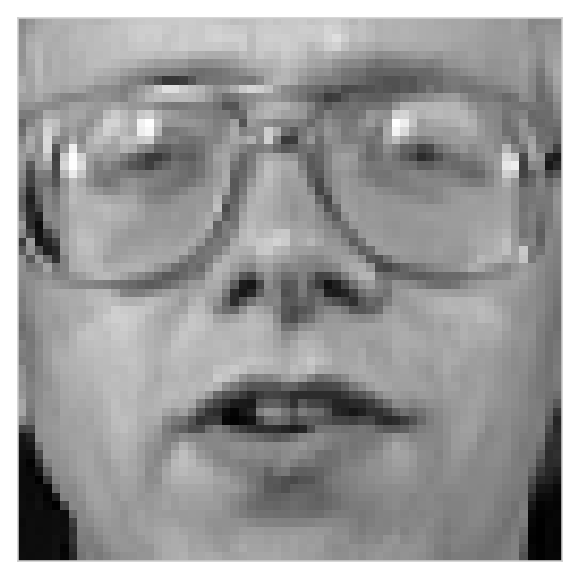

In [10]:
plot_image_matrix(process_image(face10))

Let's pull out a matrix of pixels — just the eye of face No. 40.

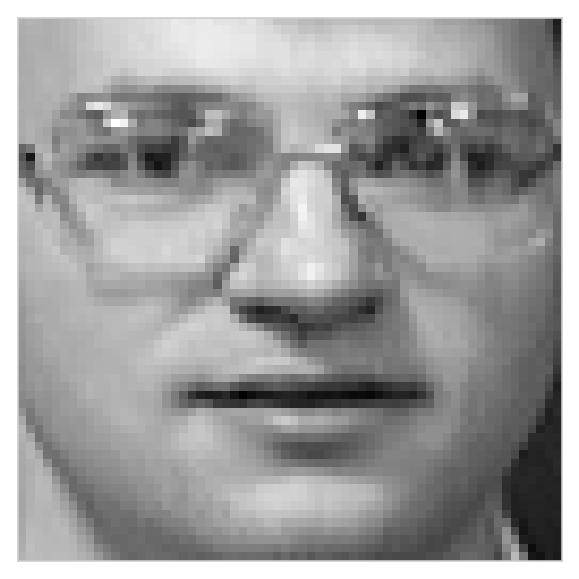

In [11]:
plot_image_matrix(process_image(faces[50]))

In [12]:
# This gets a two-dimensional matrix — columns five to 30 and pixel rows 10 to 15.
#    Knowing this, what would you predict eye.shape to be? Verify your answer.

eye = process_image(faces[50])[5:30, 10:15]

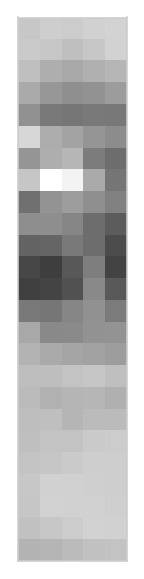

In [13]:
plot_image_matrix(eye)

---

### 3) Correlation and covariance of a matrix.

In this section, we'll be treating each row of the eye image as an example and each column will be a feature. The correlation between the columns will be how often all five columns change their pixel values together. 

In the eye image, notice that the five columns are approximately the same across each row. So, we would expect them to have a high correlation.

#### 3.A) Correlation matrix.

You should be able to intuitively describe the correlation matrix below:

- Why is a correlation matrix diagonal? What do the `1`s mean?
- Why is this particular correlation matrix five by five? What does each row/column correspond to?
- What does it mean that all correlations are highly positive, in terms of the pixels?
- For PCA, would it be good or bad for each column of pixels to be highly correlated?

In [14]:
np.corrcoef(eye, rowvar=False)

array([[1.        , 0.89679602, 0.84243288, 0.73569311, 0.81209014],
       [0.89679602, 1.        , 0.98238476, 0.7519262 , 0.73714626],
       [0.84243288, 0.98238476, 1.        , 0.78569793, 0.73761145],
       [0.73569311, 0.7519262 , 0.78569793, 1.        , 0.93985714],
       [0.81209014, 0.73714626, 0.73761145, 0.93985714, 1.        ]])

Let's interpret this correlation matrix:

- **Because `rowvar=False`, the columns are treated as the variables/features.**
  - Therefore, we can consider each row to be a data point with five features — in this case, pixels.


- **What does it mean that these five pixels are highly correlated with each other?**
  - When column A's pixel is lit, is column B's pixel also lit? When column A's pixel is off, is column B's pixel also off? If so, A and B would have a positive correlation.
  - Looking at the eye image, all five columns are either all on or all off (generally speaking), so they should have positive correlations.


- **Verify your understanding:** The lowest correlation is the first column versus the fourth column (0.736). Looking at the image, would you expect these two to have the lowest correlation? If so, then you have evidence that these results are correct.


- **How does this relate to PCA?** A high correlation between columns means that our data representation is wasteful. In the eye matrix, all five pixel columns contain nearly identical information. We could clearly copy the first column five times and get a very similar image. Once PCA is performed, no two separate columns will be correlated (i.e., our correlation matrix will be the identity matrix).

#### 3.B) Covariance

Now that you understand the correlation matrix, let's use these intuitions to examine the covariance matrix and gain a similar understanding. Also, try to intuitively understand how the correlation and covariance matrices are related — it’s the [standardized covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix#Correlation_matrix). (The correlation is restricted to the range [-1, 1].)

The [covariance of a matrix $X$](https://en.wikipedia.org/wiki/Covariance_matrix) is defined:

### $$ Cov_X = \frac{X^T X}{n-1} $$

In [15]:
# Center the eye image — this is necessary for manual covariance calculation.
eye_cent = eye - eye.mean(axis=0)
manual_cov = np.dot(eye_cent.T, eye_cent) / (eye_cent.shape[0] - 1)

# NumPy defaults to assuming that the rows are the variables and the columns are observations.
# Setting rowvar=False is essential if we want to think about the columns 
# as the variables and calculate the covariance matrix accordingly.
numpy_cov = np.cov(eye, rowvar=False)

In [16]:
# You can see that the manual calculation is the same as the NumPy calculation.
manual_cov[0, 0], numpy_cov[0, 0]

(0.027281007, 0.02728100600086516)

In [17]:
manual_cov

array([[0.02728101, 0.02643268, 0.02162093, 0.01639091, 0.02475584],
       [0.02643268, 0.03184451, 0.02724005, 0.01809959, 0.02427808],
       [0.02162093, 0.02724005, 0.02414449, 0.016468  , 0.02115339],
       [0.01639091, 0.01809959, 0.016468  , 0.01819502, 0.02339815],
       [0.02475584, 0.02427808, 0.02115339, 0.02339815, 0.0340633 ]],
      dtype=float32)

In [18]:
# We use np.allclose(), because you should never compare floats directly.
#    (For example, `0.1 == 0.4 - 0.3` is false.)

# They are basically the same numbers:
np.allclose(manual_cov, numpy_cov)

True

---

### 4) An ideal data representation.

An ideal covariance matrix for data would have large numbers (variances) along the diagonal. This would indicate a large amount of signal in the data. It would also have zero values in the off-diagonal elements, because these values indicate redundancy across our variables. 

Currently, our covariance matrix is not diagonal. You can see this clearly, as there are many non-zero elements outside of the diagonal. This means that our variables (columns of pixels) are correlated with each other. One way of thinking about this — and the reason that PCA seeks to decorrelate the data — is that correlation between our variables indicates that they are redundant. We don't need as many to represent the same amount of variance in the data set.

With PCA, we seek a new representation of our data such that the columns, or variables, are uncorrelated. We also want the new variables ordered by importance so that they maximize the information in the data represented by variance in order. 

---

#### Defining the new representation of our data, $Y$.

But how do we do this? We’ll derive a transformation on our data so that the transformed data have the ideal covariance matrix described above. Our new representation will have no correlation between variables, and the variables will be ordered by importance.

We can define new matrices $Y$ and $P$ such that:

#### $$ Y = XP $$

$Y$ will be our new representation of the data, where the covariance of matrix $Y$ is diagonal (meaning the columns are uncorrelated).

#### $$ Cov_Y = \frac{Y^{T}Y}{n-1} \text{ is a diagonal matrix} $$

PCA assumes that the $P$ matrix will be “orthonormal,” meaning that the columns of $P$ are orthogonal as well as normalized. $P$ is the matrix that will perform the rotation of the $X$ matrix into the new axis space for $Y$. $P$ will be orthonormal because of how PCA re-characterizes the data:

1) Find a $p_1$ direction that maximizes the variance in $X$.
2) Find a $p_2$ that maximizes variance in $X$ _such that $p_2$ is orthogonal to $p_1$_.
3) Find a $p_3$ that maximizes variance in $X$ _such that $p_3$ is orthogonal to $p_1$ and $p_2$._
4) Repeat this for all $p$ columns.

We can rewrite the covariance of $Y$ as a function of $P$ and the covariance of $X$:

### $$ Cov_Y = \frac{Y^{T}Y}{n-1} \\
Cov_Y = \frac{(XP)^{T}(XP)}{n-1} \\
Cov_Y = \frac{P^T X^T X P}{n-1} \\
Cov_Y = P^T\left(\frac{X^TX}{n-1}\right)P \\
Cov_Y = P^TCov_X P$$

So, where do we go from here? Luckily, any symmetric matrix, such as a covariance matrix, has orthogonal eigenvectors.

---

### If a Matrix is Orthogonally Diagonalizable, It Is Also Symmetric

Say we have matrix $A$ and its transpose, $A^T$. If a matrix is symmetric, it means that it’s equal to its transpose ($A = A^T$). Say we also have a diagonal matrix, $D$, and a matrix $E$ such that:

### $$ A = EDE^T $$

We can write out the transpose of $A$, $A^T$ as:

### $$ A^T = (EDE^T)^T $$

The transpose of the dot products of matrices is equivalent to the product of their transpose in reverse order. For example, $(AB)^T = B^T A^T$.

### $$ A^T = E^{TT}D^TE^T \\
A^T = ED^TE^T$$

We have already defined $D$ to be a diagonal matrix, so by definition, $D^T = D$. You can see that $A^T$ is in fact equal to $A$:

### $$ A^T = EDE^T  = A$$

So, if $A$ is equal to its transpose, it’s orthogonally diagonalizable. 



---

#### The diagonalization of a symmetric matrix is done using its eigenvectors.

Again, $A$ is our symmetric matrix such that $A = A^T$. Now, we define the $E$ matrix to be the matrix of the eigenvectors of $A$. 

Recall that the eigenvectors of a matrix are the vectors that do not change direction when multiplied by the matrix and are only scaled according to their corresponding eigenvalues. An eigenvector, $e_i$, and its corresponding eigenvalue, $\lambda_i$, are described as:

#### $$ Ae_i = \lambda_i e_i $$

Likewise, the determinant of a matrix, $A$, minus its eigenvalues, times the identity matrix $I$ will equal zero:

#### $$ det(A - \lambda I) = 0 $$

You can think of the determinant as a "signed volume" of the space defined by $A$. The eigenvalues represent the scaling of the $A$ matrix relative to the unit volume.

We can write out the equation like this:

#### $$ AE = ED $$

Because this is equivalent to the definition of the eigenvectors and eigenvalues above, $A$ multiplied by the matrix of the eigenvectors is equivalent to the matrix of the eigenvectors multiplied by a diagonal matrix that represent the eigenvalues, $\lambda$.

Remember that if $A$ is symmetric, $A = A^T$. Write out two different equations with two different eigenvalue and eigenvector pairs:

### $$ A e_1 = \lambda_1 e_1 \\
A e_2 = \lambda_2 e_2 $$

Pre-multiply the first equation by the transpose of $e_2$ and the second equation by the transpose of $e_1$:

### $$ e_2^T A e_1 = \lambda_1 e_2^T  e_1 \\
e_1^T A e_2 = \lambda_2 e_1^T  e_2 $$

We know that $A$ is symmetric, so (with just the first equation) we can plug in $A^T$:

### $$ e_2^T A^T e_1 = \lambda_1 e_2^T e_1 $$

Using the rule that $(AB)^T = B^T A^T$:

### $$ (A e_2)^T e_1 =  \lambda_1 e_2^T e_1 $$

Substitute in the eigenvalue and eigenvector representation for $A e_2$:

### $$ (\lambda_2 e_2)^T e_1 = \lambda_1 e_2^T e_1 \\
\lambda_2 e_2^T e_1 = \lambda_1 e_2^T e_1$$

And so:

### $$ (\lambda_2 - \lambda_1)(e_2^T e_1) = 0 $$

Therefore, $e_2^T e_1$ must equal zero (the eigenvalues are unique). This holds true for any of the eigenvectors, not just the first two. The eigenvectors of the symmetric matrix are therefore orthogonal.

Let's go back to the equation we had at the beginning:

### $$ AE = ED $$

We can rewrite this as:

### $$ A = EDE^{-1} $$

A property of an orthogonal matrix is that its inverse is also its transpose: $E^T = E^{-1}$. As we have just shown, our $E$ matrix of the eigenvectors is in fact orthogonal for the symmetric matrix $A$. Using this fact, we can finally rewrite the equation as:

### $$ A = EDE^T $$

We know that a symmetric matrix is diagonalized by its eigenvectors.

---

### Diagonalizing the Covariance of Matrix $Y$ is Done Using the Eigenvalues of the Covariance of $X$

Now, let’s go all the way back to our equation for the covariance of our desired $Y$ matrix, which we're going to make diagonal:

### $$ Cov_Y = P^TCov_X P$$

Remember, we want $Cov_Y$ to be a diagonal matrix. How should we do this? Our desired outcome is:

### $$ Cov_Y = D$$

We need to set the right-hand side of the equation as equal to $D$:

### $$ P^TCov_X P = D $$

If we set the columns of $P$ to be the eigenvectors of the covariance matrix of $X$, then $P$ is equivalent to the $E$ in our formula for the symmetric matrix $A$ above.

We can plug this in to the formula in place of $Cov_X$:

### $$ P^T (PDP^T) P = D \\
(P^TP)D(P^TP) = D $$

Because the eigenvectors $P$ are orthogonal, $P^T = P^{-1}$, so:

### $$ (P^{-1}P) D (P^{-1}P) = D \\
D = D $$

Therefore, we know that the covariance matrix of $Y$ is a diagonal matrix if we set $P$ to be the eigenvalues of the covariance matrix of $X$:

### $$ Cov_Y = D $$

### 5) Manually code PCA.

We can manually code PCA to prove its use to ourselves. Below, we'll work through this process for the `eye_cent` matrix as `X`:

In [19]:
X = eye_cent
cov_X = np.cov(eye_cent, rowvar=False)
cov_X

array([[0.02728101, 0.02643268, 0.02162093, 0.01639091, 0.02475585],
       [0.02643268, 0.03184451, 0.02724005, 0.01809959, 0.02427808],
       [0.02162093, 0.02724005, 0.02414448, 0.016468  , 0.02115339],
       [0.01639091, 0.01809959, 0.016468  , 0.01819502, 0.02339815],
       [0.02475585, 0.02427808, 0.02115339, 0.02339815, 0.0340633 ]])

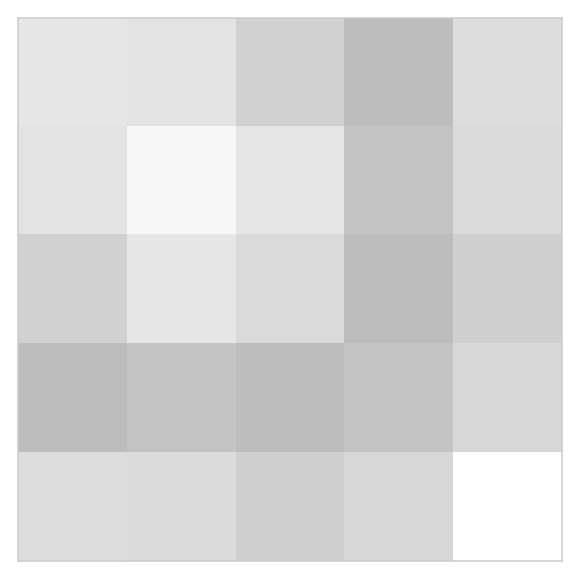

In [20]:
plot_image_matrix(cov_X)

In [22]:
# Use NumPy's linalg.eigh to get the eigenvalues and vectors for a symmetric matrix:
eigval, eigvec = np.linalg.eigh(cov_X)

print(eigval)
print(eigvec)

[0.00022276 0.00075275 0.00497803 0.01302775 0.11654703]
[[ 0.17113608  0.35719895 -0.78281482 -0.16196171 -0.451764  ]
 [-0.6817407  -0.19047562  0.14938273 -0.48097297 -0.49527614]
 [ 0.69552901 -0.10072776  0.42983835 -0.3722022  -0.42754862]
 [-0.14588119  0.71303589  0.41188149  0.41788152 -0.35500306]
 [ 0.03000217 -0.56352612 -0.10236397  0.65519002 -0.49171723]]


In [23]:
# Sort the eigenvectors by largest to smallest eigenvalue.
idx = np.argsort(eigval)[::-1]     # Gets the indices of the smallest to largest, then reverses it.
eigvec = eigvec[:,idx]             # Returns the eigenvectors in the order above.
eigvec

array([[-0.451764  , -0.16196171, -0.78281482,  0.35719895,  0.17113608],
       [-0.49527614, -0.48097297,  0.14938273, -0.19047562, -0.6817407 ],
       [-0.42754862, -0.3722022 ,  0.42983835, -0.10072776,  0.69552901],
       [-0.35500306,  0.41788152,  0.41188149,  0.71303589, -0.14588119],
       [-0.49171723,  0.65519002, -0.10236397, -0.56352612,  0.03000217]])

In [24]:
# Perform the dot product of X with the eigenvectors to get Y.
Y = np.dot(X, eigvec)
Y[0:3]

array([[-0.36101215,  0.06284877,  0.02714224, -0.00217888, -0.00233566],
       [-0.31759933,  0.07147742, -0.02146009, -0.01091403, -0.01239504],
       [-0.12445328,  0.04922555, -0.06837268, -0.00173076, -0.00675389]])

In [25]:
# Compute the covariance for Y to verify that the columns of Y are indeed uncorrelated.
cov_Y = np.cov(Y, rowvar=False)
cov_Y

array([[ 1.16547027e-01, -7.21868607e-18,  1.40601739e-17,
        -1.43012141e-17, -1.58508082e-17],
       [-7.21868607e-18,  1.30277495e-02,  7.54653812e-18,
        -1.15179341e-17, -3.19045204e-19],
       [ 1.40601739e-17,  7.54653812e-18,  4.97803126e-03,
        -1.36397502e-17, -6.26682296e-18],
       [-1.43012141e-17, -1.15179341e-17, -1.36397502e-17,
         7.52748301e-04,  1.91376004e-18],
       [-1.58508082e-17, -3.19045204e-19, -6.26682296e-18,
         1.91376004e-18,  2.22761865e-04]])

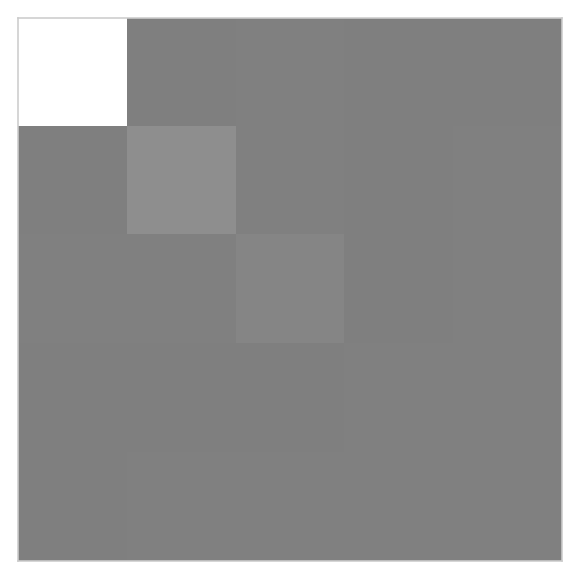

In [26]:
# The image of the covariance matrix shows that the off-diagonal elements are
# all essentially zero.
plot_image_matrix(cov_Y)

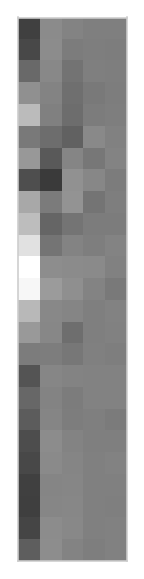

In [27]:
# You can also see that the rightmost column of Y contains the most variance, although these
# new variables no longer look like an eye.
plot_image_matrix(Y)

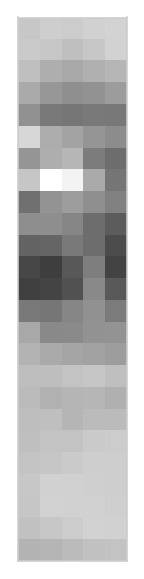

In [28]:
# Verify it here with the actual eye.
#   Does it make sense that the rightmost column would have the most variance?

plot_image_matrix(eye)

---

<a id="svd"></a>
### 6) Singular value decomposition (SVD) to perform PCA.

SVD is the most common method for performing PCA. It's similar to the eigendecomposition of the covariance matrix done in the previous section. 

Say we again have matrix $X$ with variables in the columns, as well as the square matrix defined by $X^TX$.

If $v_i$ is an orthonormal eigenvector of $X^TX$ and $\lambda_i$ is its corresponding eigenvalue, we have:

### $$ X^TX v_i = \lambda_i v_i $$

If you instead multiply the matrix $X$ by the eigenvectors of its covariance matrix, you have the following relation:

### $$ X v_i = \sigma_i u_i $$

Where $\sigma_i = \sqrt{\lambda_i}$ and $u_i = \frac{1}{\sigma_i}X v_i$.

The $U$ and $V$ matrices of the vectors are both orthonormal and define a set of new bases for $X$ (a new rotated set of axes).

You can represent the "singular values" $\sigma$ with the diagonal matrix $\Sigma$ where:

### $$ \Sigma = \begin{pmatrix}\sigma_{1} \\
& \sigma_{2} \\
& & \ddots \\
& & & \sigma_{n}\end{pmatrix} $$

The SVD is then written as:

### $$ XV = U \Sigma \\
X = U \Sigma V^{-1} \\
X = U \Sigma V^T $$


Graphically, we can show this in both the case of a single eigenvector and one of the full matrix of eigenvectors. For the equation with one eigenvector:

### $$ X v_i = \sigma_i u_i $$

looks like:

### $$ \begin{pmatrix}x_{1,1} \\
& \ddots \\
& & x_{n,m}\end{pmatrix} \cdot \begin{pmatrix} v_{1} \\ \ddots \\ v_{m} \end{pmatrix} = \sigma \cdot \begin{pmatrix} u_{1} \\ \ddots \\ u_{n} \end{pmatrix}$$


Likewise, the equation with full matrices $V$ and $U$:

### $$ XV = U \Sigma $$

looks like:

### $$ \begin{pmatrix}x_{1,1} \\
& \ddots \\
& & x_{n,m}\end{pmatrix} \cdot 
\begin{pmatrix} v_{1,1} \\ 
& \ddots \\ 
& & v_{m,m} \end{pmatrix} = 
\begin{pmatrix} u_{1,1} \\ 
& \ddots \\ 
& & u_{n,n} \end{pmatrix} \cdot 
\begin{pmatrix} \sigma_{1,1} \\ 
& \ddots \\ 
& & \sigma_{n,m} \end{pmatrix} $$

Keep in mind that the matrices $V$ and $U$ will typically have to be "filled in" with extra orthogonal vectors to compensate for the fact that $X$ is not a square matrix.

So, how do we use SVD to perform PCA? As it turns out, the $V$ matrix is equivalent to the $P$ that we calculated previously. It is the matrix that transforms the information contained in $X$ to a new base in which the columns are orthogonal to each other.


### 7) Manually code SVD.

In [29]:
# Perform the SVD on X.
U, S, VT = np.linalg.svd(X)

In [30]:
# Print out V, the transpose of VT that comes out of np.inalg.svd.
VT.T

array([[-0.451764  ,  0.1619617 , -0.7828148 ,  0.35719895, -0.17113608],
       [-0.49527612,  0.48097298,  0.14938273, -0.19047561,  0.6817407 ],
       [-0.42754862,  0.3722022 ,  0.42983836, -0.10072777, -0.695529  ],
       [-0.35500306, -0.41788152,  0.41188148,  0.7130359 ,  0.14588119],
       [-0.49171722, -0.65519   , -0.10236397, -0.5635261 , -0.03000217]],
      dtype=float32)

In [31]:
# These are the same as the ordered eigenvectors that we calculated before
# (some of the signs can be flipped due to slight differences in calculation,
# but the magnitudes are equivalent — which is the important part).
eigvec

array([[-0.451764  , -0.16196171, -0.78281482,  0.35719895,  0.17113608],
       [-0.49527614, -0.48097297,  0.14938273, -0.19047562, -0.6817407 ],
       [-0.42754862, -0.3722022 ,  0.42983835, -0.10072776,  0.69552901],
       [-0.35500306,  0.41788152,  0.41188149,  0.71303589, -0.14588119],
       [-0.49171723,  0.65519002, -0.10236397, -0.56352612,  0.03000217]])

One of the benefits of using the SVD formulation is that it makes it fairly straightforward to reconstruct a version of our original matrix, $X$, using only some of the principal components. The first set of principal components often accounts for a large amount of the variance in the data, so you can get back most of the original set with a fraction of the dimensionality.

Let's first do the SVD and visualize the matrices for our `eye_cent` image. 

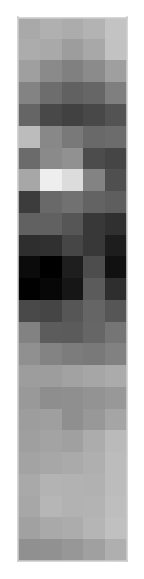

In [32]:
# The original image of the eye:
plot_image_matrix(eye_cent)

In [33]:
# Perform an SVD on the eye_cent data. The argument full_matrices=False only 
# returns the relevant parts of U and VT (remember that SVD will fill in orthogonal vectors if X is not square).

U, S, VT = np.linalg.svd(eye_cent, full_matrices=False)
S = np.diag(S)

In [36]:
print(eye_cent.shape, U.shape, S.shape, VT.shape)

(25, 5) (25, 5) (5, 5) (5, 5)


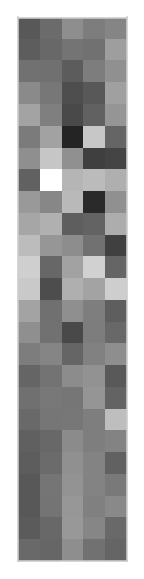

In [37]:
# Plot the U matrix.
plot_image_matrix(U)

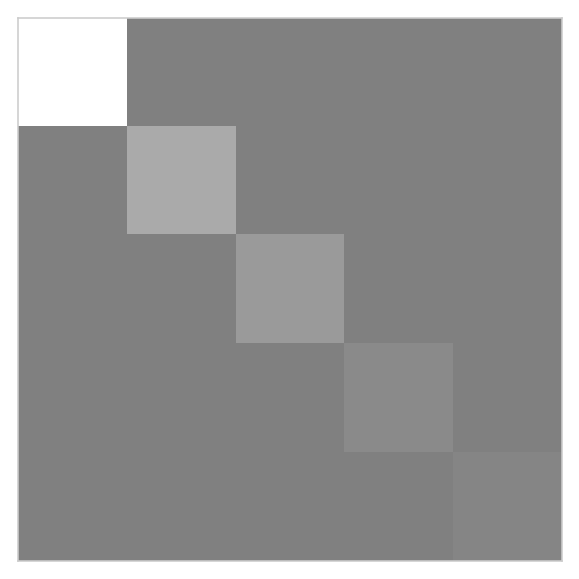

In [38]:
plot_image_matrix(S)

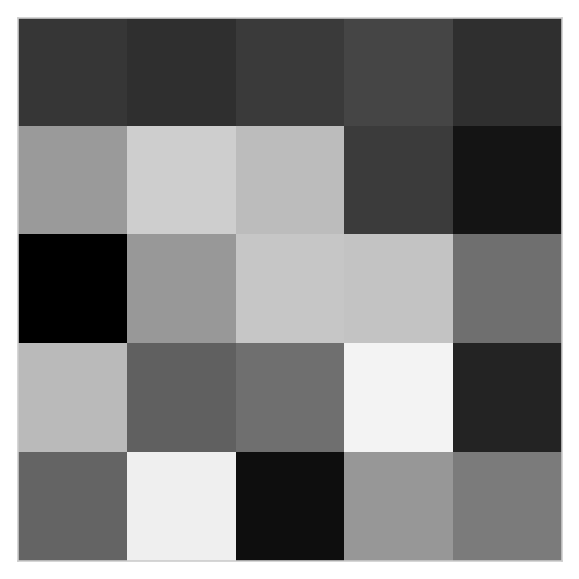

In [39]:
plot_image_matrix(VT)

We can reconstruct the original image exactly using the formula $X = U\Sigma V^T$.

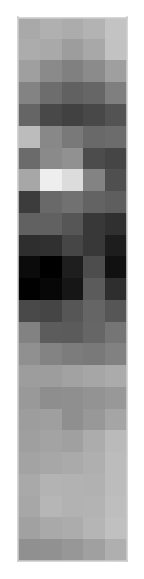

In [40]:
X_recon = np.dot(U, np.dot(S, VT))
plot_image_matrix(X_recon)

However, we can do the same with only two of the singular value dimensions. Because the singular values are ordered by the variance they account for, we can retain much of the original image using a fraction of the values. 

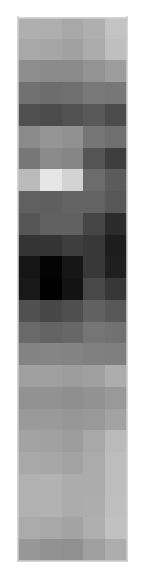

In [41]:
pc = 2
X_recon = np.dot(U[:, :pc], np.dot(S[:pc, :pc], VT[:pc, :]))
plot_image_matrix(X_recon)

This is even more apparent with a full-face image. Below is image number 50:

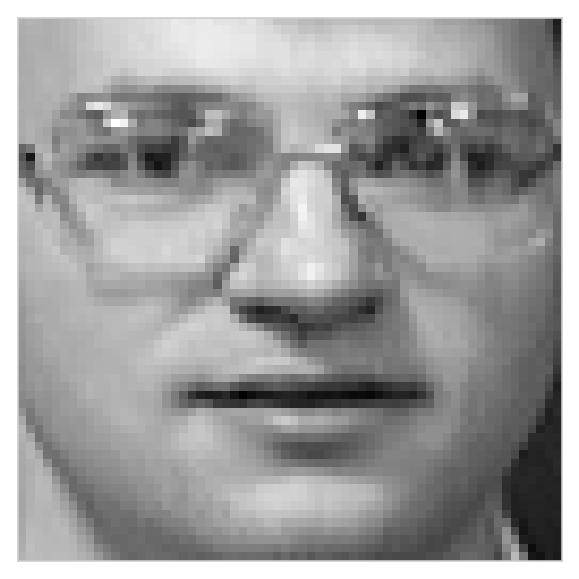

In [42]:
face = process_image(faces[50])
plot_image_matrix(face)

We perform SVD on this image and look at the singular value matrix to get a feel for how many components are actually important (and account for reasonable variance).

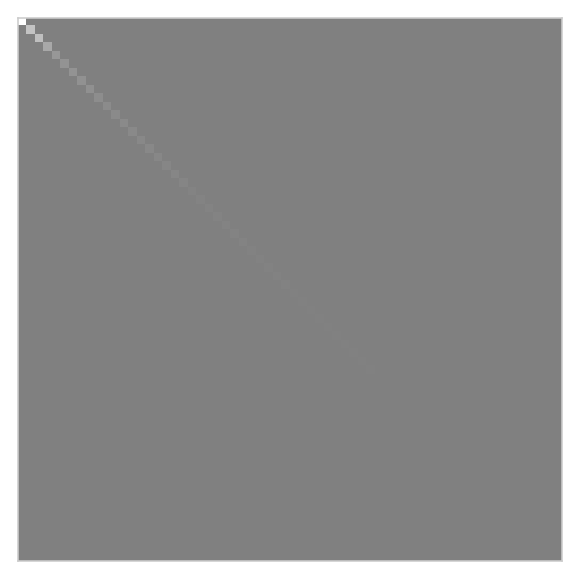

In [43]:
U, S, VT = np.linalg.svd(face, full_matrices=False)
S = np.diag(S)
plot_image_matrix(S)

It looks like the first five or six have a decent proportion of the variance across the pixel columns. We can look at what the face reconstruction looks like just by using those first five singular values. 

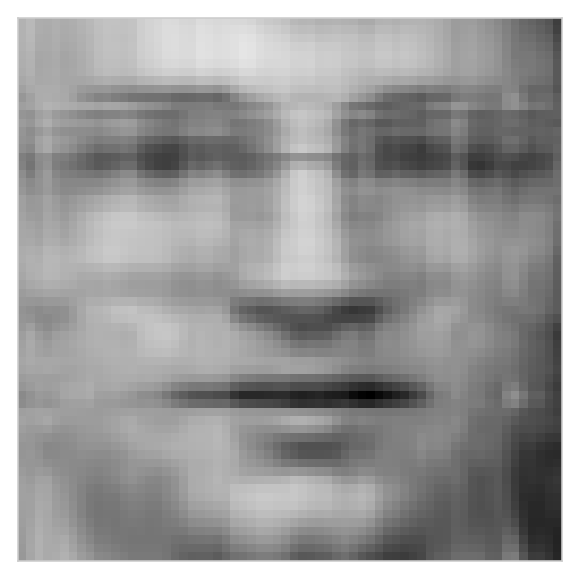

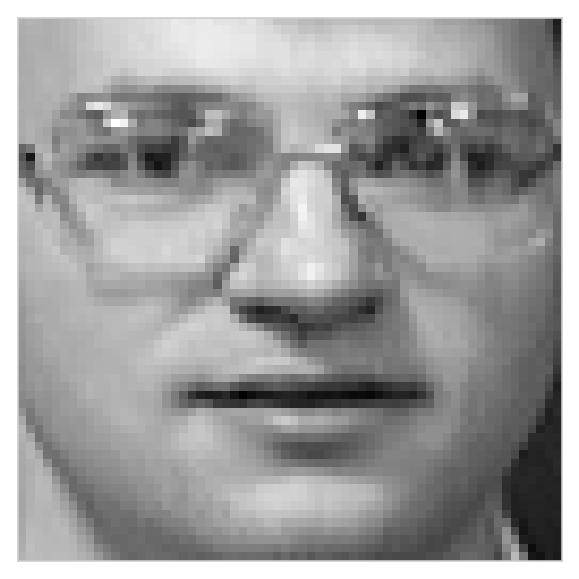

In [44]:
pc = 5
face_recon = np.dot(U[:, :pc], np.dot(S[:pc, :pc], VT[:pc, :]))
plot_image_matrix(face_recon)
plot_image_matrix(process_image(faces[50]))  # Original for comparison (64 columns).

To see how reconstruction is affected by different principal components, try adjusting `pc`. What is the smallest value of `pc` we can have so that the image has minimal loss?

Congratulations, you just wrote an image compressor!